# Line Plots

![](images/why-lines-instead-of-bars.png) 

The line plot is a fairly common plot type that is used to plot the trend of one numeric variable against values of a second variable. In contrast to a scatterplot, where all data points are plotted, in a line plot, only one point is plotted for every unique x-value or bin of x-values (like a histogram). If there are multiple observations in an x-bin, then the y-value of the point plotted in the line plot will be a summary statistic (like mean or median) of the data in the bin. The plotted points are connected with a line that emphasizes the sequential or connected nature of the x-values.

If the x-variable represents time, then a line plot of the data is frequently known as a __time series__ plot. Often, we have only one observation per time period, like in stock or currency charts. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

fuel_econ = pd.read_csv('data/fuel_econ.csv')
fuel_econ.head()

,id,make,model,year,VClass,drive,trans,fuelType,cylinders,displ,pv2,pv4,city,UCity,highway,UHighway,comb,co2,feScore,ghgScore
0,32204,Nissan,GT-R,2013,Subcompact Cars,All-Wheel Drive,Automatic (AM6),Premium Gasoline,6,3.8,79,0,16.4596,20.2988,22.5568,30.1798,18.7389,471,4,4
1,32205,Volkswagen,CC,2013,Compact Cars,Front-Wheel Drive,Automatic (AM-S6),Premium Gasoline,4,2.0,94,0,21.8706,26.9770,31.0367,42.4936,25.2227,349,6,6
2,32206,Volkswagen,CC,2013,Compact Cars,Front-Wheel Drive,Automatic (S6),Premium Gasoline,6,3.6,94,0,17.4935,21.2000,26.5716,35.1000,20.6716,429,5,5
3,32207,Volkswagen,CC 4motion,2013,Compact Cars,All-Wheel Drive,Automatic (S6),Premium Gasoline,6,3.6,94,0,16.9415,20.5000,25.2190,33.5000,19.8774,446,5,5
4,32208,Chevrolet,Malibu eAssist,2013,Midsize Cars,Front-Wheel Drive,Automatic (S6),Regular Gasoline,4,2.4,0,95,24.7726,31.9796,35.5340,51.8816,28.6813,310,8,8


Text(0,0.5,'Avg. combined fuel eff (mpg)')

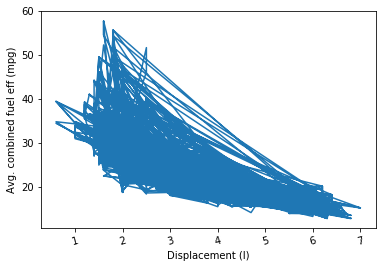

In [6]:
plt.errorbar(data = fuel_econ, x = 'displ', y = 'comb')
plt.xticks(rotation = 15)
plt.xlabel('Displacement (l)')
plt.ylabel('Avg. combined fuel eff (mpg)')

If we just blindly stick a dataframe into the function without considering its structure, we might end up with a mess like the above. The function just plots all the data points as a line, connecting values from the first row of the dataframe to the last row. In order to create the line plot as intended, we need to do additional work to summarize the data.

Text(0,0.5,'comb')

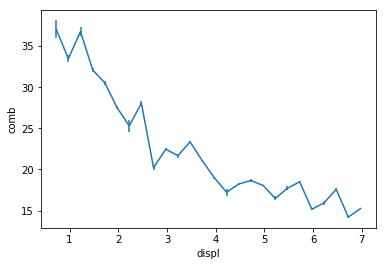

In [9]:
# Set bin edges, compute centers
bin_size = 0.25
xbin_edges = np.arange(0.6, fuel_econ['displ'].max()+bin_size, bin_size)
xbin_centers = (xbin_edges + bin_size/2)[:-1]

# compute statistics in each bin
data_xbins = pd.cut(fuel_econ['displ'], xbin_edges, right = False, include_lowest = True)
y_means = fuel_econ['comb'].groupby(data_xbins).mean()
y_sems = fuel_econ['comb'].groupby(data_xbins).sem()

# plot the summarized data
plt.errorbar(x = xbin_centers, y = y_means, yerr = y_sems)
plt.xlabel('displ')
plt.ylabel('comb')

Since the x-variable ('num_var1') is continuous, we first set a number of bins into which the data will be grouped. In addition to the usual edges, the center of each bin is also computed for later plotting. For the points in each bin, we compute the mean and standard error of the mean

### Alternate Variations
Instead of computing summary statistics on fixed bins, you can also make computations on a rolling window through use of pandas' ```rolling``` method. Since the rolling window will make computations on sequential rows of the dataframe, we should use ```sort_values``` to put the x-values in ascending order first.

In [24]:
# Compute statistics in rolling window
df_window = fuel_econ.sort_values('comb').rolling(15)
x_winmean = df_window.mean()['comb']
y_median = df_window.median()['displ']
y_q1 = df_window.quantile(.25)['displ']
y_q3 = df_window.quantile(.75)['displ']

# plot the summarized data
base_color = sb.color_palette()[0]
line_color = sb.color_palette('dark')[0]
plt.scatter(data = fuel_econ, x = 'comb', y = 'displ')
plt.errorbar(x = x_winmean, y = y_median, c = line_color)
plt.errorbar(x = x_winmean, y = y_q1, c = line_color, linestyle = '__')
plt.errorbar(x = x_winmean, y = y_q3, c = line_color, linestyle = '__')

plt.xlabel('comb')
plt.ylabel('displ')

SyntaxError: invalid syntax (<ipython-input-24-34be580c2426>, line 8)

Another bivariate application of line plots is to plot the distribution of a numeric variable for different levels of a categorical variable. This is another alternative to using violin plots, box plots, and faceted histograms. With the line plot, one line is plotted for each category level, like overlapping the histograms on top of one another. This can be accomplished through multiple ```errorbar``` calls using the methods above, or by performing multiple ```hist``` calls, setting the "histtype = step" parameter so that the bars are depicted as unfilled lines.

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


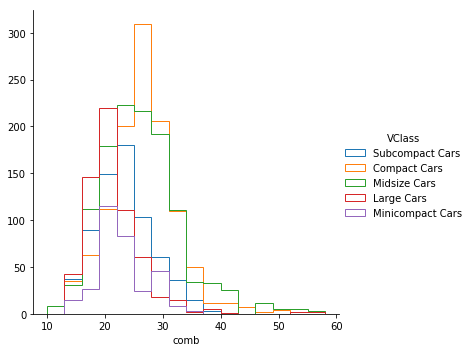

In [32]:
bin_edges = np.arange(10, fuel_econ['comb'].max()+3, 3)
g = sb.FacetGrid(data = fuel_econ, hue = 'VClass', size = 5)
g.map(plt.hist, "comb", bins = bin_edges, histtype = 'step')
g.add_legend()

Unfortunately, the "Alpha" curve seems to be pretty lost behind the other three curves since the relatively low number of counts is causing a lot of overlap. Perhaps connecting the centers of the bars with a line, like what was seen in the first ```errorbar``` example, would be better.

Functions you provide to the ```map``` method of FacetGrid objects do not need to be built-ins. Below, I've written a function to perform the summarization operations seen above to plot an ```errorbar``` line for each level of the categorical variable, then fed that function (```freq_poly```) to ```map```.

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


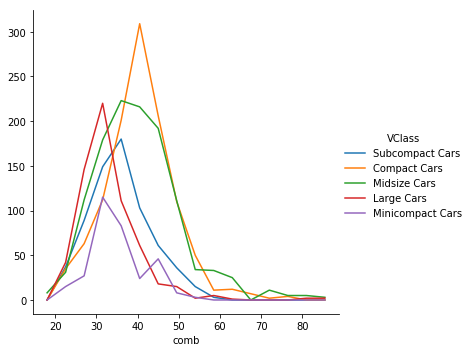

In [34]:
def freq_poly(x, bins = 10, **kwargs):
    """ Custom frequency polygon / line plot code. """
    # set bin edges if none or int specified
    if type(bins) == int:
        bins = np.linespace(x.min(), x.max(), bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1] / 2)
    
    # compute counts
    data_bins = pd.cut(x, bins, right = False, include_lowest = True)
    counts = x.groupby(data_bins).count()
    
    # create plot
    plt.errorbar(x = bin_centers, y = counts, **kwargs)
    
bin_edges = np.arange(10, fuel_econ['comb'].max()+3, 3)
g = sb.FacetGrid(data = fuel_econ, hue = 'VClass', size = 5)
g.map(freq_poly, "comb", bins = bin_edges)
g.add_legend()